## Imports and data loading

In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [27]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, explained_variance_score
import pickle
import optuna
print(f'Pickle Version: {pickle.format_version}')

Pickle Version: 4.0


In [3]:
_pth_tst = '../data/test_2022-08-08.csv'
_pth_trn = '../data/train_2021-12-24.csv'
_pth_emb = '../data/embeddings.pkl'
_pth_enc ='../data/encoders.pkl'

train = pd.read_csv(_pth_trn)
test = pd.read_csv(_pth_tst)

with open(_pth_emb, 'rb') as handle:
    embeds = pickle.load(handle)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99144 entries, 0 to 99143
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sale_Price          99144 non-null  float64
 1   Odometer            99119 non-null  float64
 2   Power               99090 non-null  float64
 3   Fuel_Urban          87810 non-null  float64
 4   Make_Code           99144 non-null  object 
 5   Family_Code         99144 non-null  object 
 6   Year_Group          99144 non-null  int64  
 7   Region_Description  99144 non-null  object 
 8   Vehicle_Code        99144 non-null  int64  
 9   adv_date            99144 non-null  object 
 10  sld_date            99144 non-null  object 
 11  inventory_days      99144 non-null  int64  
 12  age_list_day        99144 non-null  int64  
 13  age_sell_day        99144 non-null  int64  
 14  sld_wknum           99144 non-null  int64  
 15  adv_wknum           99144 non-null  int64  
 16  km_p

In [5]:
train.columns

Index(['Sale_Price', 'Odometer', 'Power', 'Fuel_Urban', 'Make_Code',
       'Family_Code', 'Year_Group', 'Region_Description', 'Vehicle_Code',
       'adv_date', 'sld_date', 'inventory_days', 'age_list_day',
       'age_sell_day', 'sld_wknum', 'adv_wknum', 'km_per_day',
       'fuel_per_power', 'odo_per_fuel', 'odo_per_power', 'pow_times_odo'],
      dtype='object')

## Retrive Encodings, Genetrate Test/Train set

In [49]:
feat_cols = ['Odometer', 'Power', 'Fuel_Urban', 'inventory_days', 
             'age_sell_day', 'km_per_day', 'fuel_per_power', 'sld_wknum', 'adv_wknum',
             'odo_per_fuel', 'odo_per_power','pow_times_odo']

enc_cols = list(embeds)
enc_cols

['Make_Code', 'Family_Code', 'Region_Description']

In [50]:
def get_embedded_feat(feat, encod_dict, feat_name='Family_Code'):
    '''Return embeddings from feature column using encoded dict
    '''
    feat_df = feat.to_frame()
    encodings = encod_dict[feat_name].reset_index()
    feat_tranf = feat_df.merge(encodings, how='left', left_on=[feat_name], right_on=['index'], indicator=True)
    print(feat_tranf._merge.value_counts())
    return feat_tranf.loc[:,[c for c in encodings.columns if c.startswith(feat_name)]]

In [51]:
embed_dflist = []
embed_dflist_test = []


for f in list(embeds):
    df = get_embedded_feat(train[f], embeds, feat_name=f)
    embed_dflist.append(df)
    df_test = get_embedded_feat(test[f], embeds, feat_name=f)
    embed_dflist_test.append(df_test)

both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17496
left_only         1
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17461
left_only        36
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17497
left_only         0
right_only        0
Name: _merge, dtype: int64


In [52]:
X_train_df = pd.concat([train.loc[:,feat_cols]]+embed_dflist, axis=1)
y_train = train.loc[:,'Sale_Price']

X_test_df = pd.concat([test.loc[:,feat_cols]]+embed_dflist_test, axis=1)
y_test = test.loc[:,'Sale_Price']

In [53]:
X_train_df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Odometer,99119.0,80119.0,58326.0,0.0,37745.5,70801.0,111000.0,4000380.0
Power,99090.0,140.2,51.5,28.0,110.0,129.0,147.0,545.0
Fuel_Urban,87810.0,10.3,2.8,0.9,8.6,9.9,11.3,26.4
inventory_days,99144.0,35.2,38.2,1.0,14.0,27.0,46.0,2086.0
age_sell_day,99144.0,2189.3,1283.0,58.0,1269.0,1953.0,2879.0,9467.0
km_per_day,99119.0,36.5,20.7,0.0,23.2,34.1,46.6,2132.4
fuel_per_power,87810.0,0.1,0.0,0.0,0.1,0.1,0.1,0.2
sld_wknum,99144.0,27.6,14.9,1.0,15.0,28.0,40.0,53.0
adv_wknum,99144.0,27.2,14.7,1.0,15.0,27.0,40.0,53.0
odo_per_fuel,87789.0,7482.1,5571.3,0.0,3611.7,6639.8,10290.0,519529.9


In [54]:
knn = KNNImputer()
knn.fit(X_train_df)
X_train = knn.transform(X_train_df)
X_test = knn.transform(X_test_df)

<AxesSubplot:>

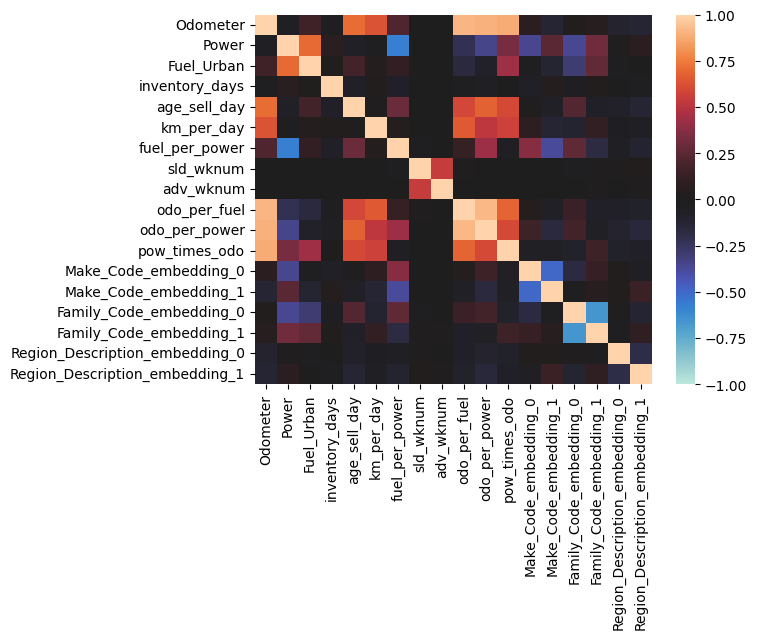

In [55]:
sns.heatmap(X_train_df.corr(), vmax=1, vmin=-1, center=0)

## Ridge Regression

In [56]:
# Tuning with optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-8, 1e8, log=True)
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    
    return cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=10, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-29 14:25:59,634] A new study created in memory with name: no-name-00755fad-7385-463f-a230-068854770bdb
[I 2022-08-29 14:26:03,971] Trial 0 finished with value: 0.09966078863636349 and parameters: {'alpha': 2861604.6855500895}. Best is trial 0 with value: 0.09966078863636349.
[I 2022-08-29 14:26:04,254] Trial 1 finished with value: 0.7727082952020056 and parameters: {'alpha': 3.202755205863415e-05}. Best is trial 1 with value: 0.7727082952020056.
[I 2022-08-29 14:26:04,527] Trial 2 finished with value: 0.7727082958326146 and parameters: {'alpha': 0.0005502721179062623}. Best is trial 2 with value: 0.7727082958326146.
[I 2022-08-29 14:26:04,801] Trial 3 finished with value: 0.7727082951631885 and parameters: {'alpha': 1.2712305740178557e-07}. Best is trial 2 with value: 0.7727082958326146.
[I 2022-08-29 14:26:05,077] Trial 4 finished with value: 0.6279665903221852 and parameters: {'alpha': 142010.13757636116}. Best is trial 2 with value: 0.7727082958326146.
[I 2022-08-29 14:26

In [57]:
pipe = make_pipeline(StandardScaler(), Ridge(**study.best_params))
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=834.212474826877))])


In [58]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=834.212474826877))])

In [59]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

In [60]:
r2_score(y_train,y_pred_train,multioutput='variance_weighted'), explained_variance_score(y_train,y_pred_train)

(0.7856835316468811, 0.785683531646881)

In [61]:
r2_score(y_test,y_pred,multioutput='variance_weighted'), explained_variance_score(y_test,y_pred)

(0.6726385786803846, 0.7502834294686308)

/Users/bjose/opt/anaconda3/envs/auto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bjose/opt/anaconda3/envs/auto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


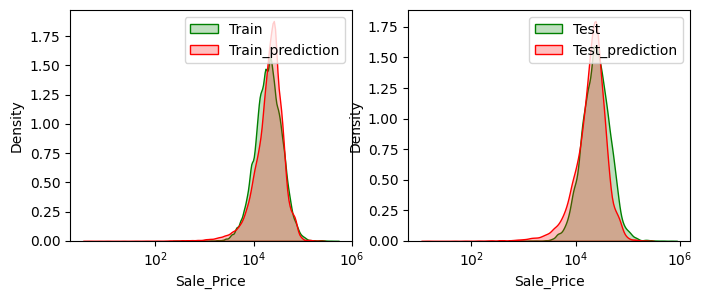

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))
sns.kdeplot(y_train,color='green',shade=True, ax=ax[0], label='Train',log_scale=True) # train
sns.kdeplot(y_pred_train,color='red',shade=True, ax=ax[0], log_scale=True)
ax[0].legend(labels=["Train","Train_prediction"])

sns.kdeplot(y_test,color='green',shade=True, ax=ax[1],log_scale=True) # test
sns.kdeplot(y_pred,color='red',shade=True, ax=ax[1],log_scale=True)
ax[1].legend(labels=["Test","Test_prediction"])

plt.show()

In [63]:
ridge_model = pipe.named_steps['ridge']
ridge_model.get_params()

{'alpha': 834.212474826877,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [64]:
sorted(list(zip(ridge_model.coef_, X_train_df.columns)), key=lambda x: x[0], reverse=True)

[(7971.108769533768, 'Power'),
 (4693.181697928947, 'Family_Code_embedding_1'),
 (3908.9498062896632, 'odo_per_power'),
 (3722.1944974638077, 'Make_Code_embedding_1'),
 (408.3396601817407, 'fuel_per_power'),
 (382.70847064337687, 'sld_wknum'),
 (100.95885379285593, 'Region_Description_embedding_0'),
 (39.0662807299751, 'Odometer'),
 (24.467830906758543, 'inventory_days'),
 (-17.682858945158642, 'adv_wknum'),
 (-31.94302255638498, 'Region_Description_embedding_1'),
 (-328.3922250978543, 'km_per_day'),
 (-1587.805436736204, 'odo_per_fuel'),
 (-2375.8842784210774, 'Fuel_Urban'),
 (-3889.216612461581, 'age_sell_day'),
 (-4294.539364880776, 'Make_Code_embedding_0'),
 (-4536.174625039374, 'Family_Code_embedding_0'),
 (-4757.214567102225, 'pow_times_odo')]

## Try log-transform of target

In [58]:
y_train_log = np.log(train.loc[:,'Sale_Price'])
y_test_log = np.log(test.loc[:,'Sale_Price'])

In [60]:
# Tuning with optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-8, 1e8, log=False)
    intercept = trial.suggest_categorical("fit_intercept", [True,False])
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha,fit_intercept=intercept))
    
    return cross_val_score(pipe, X_train, y_train_log, n_jobs=-1, cv=10, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-08-25 13:23:35,096] A new study created in memory with name: no-name-fc701696-30c2-4e48-8bf6-9ec45a53ab01
[I 2022-08-25 13:23:45,460] Trial 0 finished with value: -254.55618563507522 and parameters: {'alpha': 45961057.443678975, 'fit_intercept': False}. Best is trial 0 with value: -254.55618563507522.
[I 2022-08-25 13:23:45,851] Trial 1 finished with value: -0.015337262146454178 and parameters: {'alpha': 21863472.66816186, 'fit_intercept': True}. Best is trial 1 with value: -0.015337262146454178.
[I 2022-08-25 13:23:46,124] Trial 2 finished with value: -254.55582476304198 and parameters: {'alpha': 44500197.455604784, 'fit_intercept': False}. Best is trial 1 with value: -0.015337262146454178.
[I 2022-08-25 13:23:46,416] Trial 3 finished with value: -0.029438135233955186 and parameters: {'alpha': 61055727.10867201, 'fit_intercept': True}. Best is trial 1 with value: -0.015337262146454178.
[I 2022-08-25 13:23:46,691] Trial 4 finished with value: -0.021719079235865257 and parameter

In [61]:
study.best_params

{'alpha': 13481.328626138355, 'fit_intercept': True}

In [62]:
pipe = make_pipeline(StandardScaler(), Ridge(**study.best_params))
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=13481.328626138355))])


In [63]:
pipe.fit(X_train,y_train_log)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=13481.328626138355))])

In [64]:
y_pred_log = pipe.predict(X_test)
y_pred_train_log = pipe.predict(X_train)

y_pred_nlog = np.exp(y_pred_log)
y_pred_train_nlog = np.exp(y_pred_train_log)

In [65]:
r2_score(y_train_log, y_pred_train_log, multioutput='variance_weighted'), \
explained_variance_score(y_train_log, y_pred_train_log)

(0.8169330659404938, 0.8169330659404938)

In [66]:
r2_score(y_train_log, y_pred_train_log, multioutput='variance_weighted'), \
explained_variance_score(y_train_log, y_pred_train_log)

(0.8169330659404938, 0.8169330659404938)

In [67]:
r2_score(y_train, y_pred_train_nlog, multioutput='variance_weighted'), \
explained_variance_score(y_train, y_pred_train_nlog)

(-5.274793274410619, -5.2744889534711)

In [68]:
r2_score(y_test,y_pred_nlog, multioutput='variance_weighted'), \
explained_variance_score(y_test,y_pred_nlog)

(-5.614911888932787, -5.547920379392557)

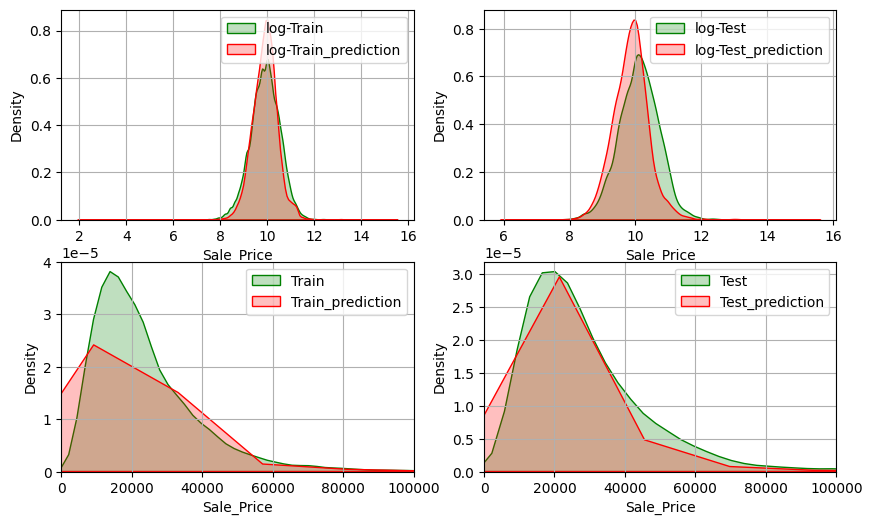

In [73]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,6))
ax = ax.ravel()
[a.grid(visible=True) for a in ax]
sns.kdeplot(y_train_log,color='green',shade=True, ax=ax[0], label='Train') # train
sns.kdeplot(y_pred_train_log,color='red',shade=True, ax=ax[0])
ax[0].legend(labels=["log-Train","log-Train_prediction"])

sns.kdeplot(y_test_log,color='green',shade=True, ax=ax[1]) # test
sns.kdeplot(y_pred_log,color='red',shade=True, ax=ax[1])
ax[1].legend(labels=["log-Test","log-Test_prediction"])

sns.kdeplot(y_train,color='green',shade=True, ax=ax[2], label='Train') # train
sns.kdeplot(y_pred_train_nlog,color='red',shade=True, ax=ax[2])
ax[2].legend(labels=["Train","Train_prediction"])
ax[2].set_xlim(0,1e5)

sns.kdeplot(y_test,color='green',shade=True, ax=ax[3]) # test
sns.kdeplot(y_pred_nlog,color='red',shade=True, ax=ax[3])
ax[3].legend(labels=["Test","Test_prediction"])
ax[3].set_xlim(0,1e5)

plt.show()

## XGBoost

In [65]:
import xgboost as xgb

In [66]:
def objective(trial, X_train=X_train, y_train=y_train):
    param = {
        "silent": 1,
        "objective": "reg:squarederror",
        "eval_metric": r2_score,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0e6),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0e6),
    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 2, 5)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 0.05)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    model = xgb.XGBRegressor(**param)
    
    return cross_val_score(model, X_train, y_train, n_jobs=-1, cv=10, scoring='r2').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
model = xgb.XGBRegressor(**study.best_params, feature_names=X_train_df.columns.tolist())

# model = xgb.XGBRegressor(feature_names=X_train_df.columns.tolist())
# model.load_model('../xgb_model.json')

In [ ]:
model.fit(X_train,y_train)

In [20]:
model.score(X_train,y_train)

0.9552666459885868

In [21]:
model.score(X_test,y_test)

0.844729238103509

In [22]:
# save xgb
# model.save_model("xgb_model.json")


# load model
# model_reload = xgb.XGBRegressor()
# model_reload.load_model("../out/xgb_model.json")

In [23]:
model.get_booster().feature_names

In [ ]:
y_pred_xgb = model.predict(X_test)
y_pred_train_xgb = model.predict(X_train)

In [41]:
r2_score(y_train,y_pred_train_xgb,multioutput='variance_weighted'), explained_variance_score(y_train,y_pred_train_xgb)

(0.9552666459885868, 0.9552666462384014)

In [42]:
r2_score(y_test,y_pred_xgb,multioutput='variance_weighted'), explained_variance_score(y_test,y_pred_xgb)

(0.844729238103509, 0.902211403817446)

/Users/bjose/opt/anaconda3/envs/auto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bjose/opt/anaconda3/envs/auto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


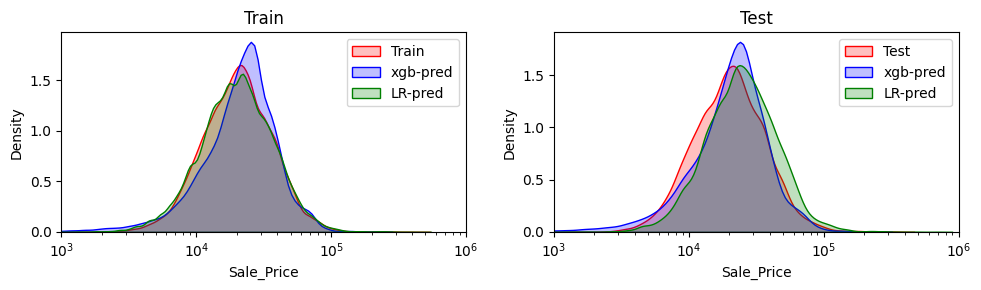

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3))

sns.kdeplot(y_pred_train_xgb,color='red',shade=True, ax=ax[0],log_scale=True)
sns.kdeplot(y_pred_train,color='blue',shade=True, ax=ax[0],log_scale=True)
sns.kdeplot(y_train,color='green',shade=True, ax=ax[0], label='Train',log_scale=True) # train
ax[0].set_title('Train')
ax[0].set_xlim(1e3,1e6)
ax[0].legend(labels=["Train","xgb-pred","LR-pred"])

sns.kdeplot(y_pred_xgb,color='red',shade=True, ax=ax[1],log_scale=True)
sns.kdeplot(y_pred,color='blue',shade=True, ax=ax[1],log_scale=True)
sns.kdeplot(y_test,color='green',shade=True, ax=ax[1],log_scale=True) # test

ax[1].set_title('Test')
ax[1].set_xlim(1e3,1e6)
ax[1].legend(labels=["Test","xgb-pred","LR-pred"])
plt.tight_layout()
plt.show()
fig.savefig('model_result_comp.png')